# Load data from MATLAB files

In [15]:
import matplotlib.pylab as plt
import numpy as np
import scipy.integrate
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
import os

data = scipy.io.loadmat('./data/reaction_diffusion_big.mat')
u = data['u']
x = data['y']
y = data['x']

# Prepare Data to Train on

Here, we find a low-rank approximation to our system. It will be the coordinates in this low-rank Principal Component space that our neural network trains on.

In [16]:
# Reshape each frame/timepoint into a vector and store as columns in a matrix; Perform SVD on this.
for i in range(u.shape[2]):
    next_frame = np.reshape(u[:,:, i], (u.shape[0] * u.shape[1], 1))
    if i == 0: 
        flattened_images = next_frame
    else: 
        flattened_images = np.hstack((flattened_images, next_frame))
        

In [17]:
# Since our data is stored as columns of the matrix X, the columns of U will store the Principal Components and
# the columns of Sigma V* give us the coordinates in this PC space.

[U,S,V] = np.linalg.svd(flattened_images, full_matrices=False)
Sigma = np.diag(S)

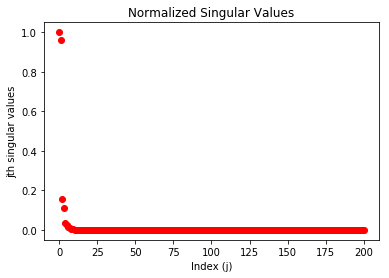

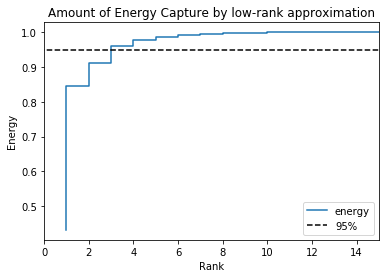

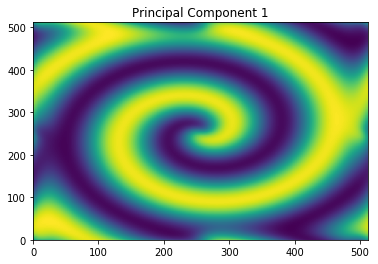

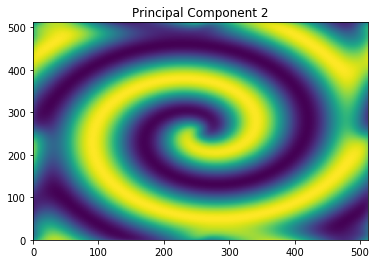

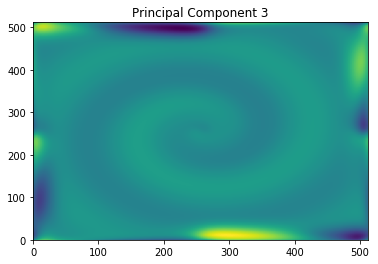

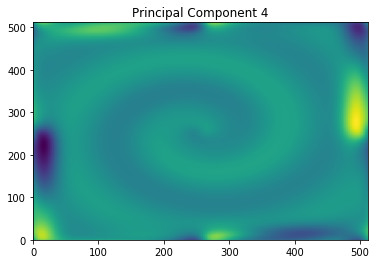

In [18]:
# Plot the normalized singular values

plt.figure()
singular_values = S / np.max(S)
plt.plot(singular_values, 'ro')
plt.xlabel('Index (j)')
plt.ylabel('jth singular values')
plt.title('Normalized Singular Values')

# Plot energy versus rank
num_show = 15
energy = np.cumsum(singular_values) / np.sum(singular_values)
plt.figure()
plt.step(list(range(1,num_show + 1)), energy[:num_show])
plt.plot([-20, 200], [0.95, 0.95], 'k--')
plt.xlim([0, num_show])
plt.xlabel('Rank')
plt.ylabel('Energy')
plt.title('Amount of Energy Capture by low-rank approximation')
plt.legend(['energy', '95%'])

# Plot the first few principal components
rank = 4
for i in range(rank):
    plt.figure()
    pc = U[:, i].reshape((u.shape[0], u.shape[1]))
    plt.pcolor(pc)
    plt.title('Principal Component ' + str(i+1))
    
U_r = U[:, :rank]
S_r = np.diag(S)[:rank, :rank]
V_r = V[:rank, :]

# inputs is the low rank coordinates (in PC space) at time t, outputs at time (t+1)
inputs = V_r.T[:-2, :]
outputs = V_r.T[1:-1, :]
test_in = V_r.T[-2, :]
test_out = V_r.T[-1, :]
    

# Build and Train Neural Network

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

l1 = 0  # L1 regularization of network weights\
l2 = 0 #1e-4 # L2 Regularization of network weights

# can define a custom activation function and pass it as a parameter with 'activation' as well. 
model = Sequential()
model.add(Dense(1000, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), input_shape = (rank,)))
model.add(Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'))
model.add(Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'))
model.add(Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'))
model.add(Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'))
model.add(Dense(1000, activation='linear'))

model.add(Dense(rank, activation='linear'))

model.compile(optimizer='adadelta', loss='mean_squared_error')

In [27]:
model.fit(inputs, outputs, 
         epochs=100,
         batch_size=100,
         shuffle=True, 
         verbose=0,
         validation_split = 0.2) # use 20 % of data as a validation dataset

# Check NN performance

Text(0.5, 1.0, 'Neural Network prediction at time (t+1)')

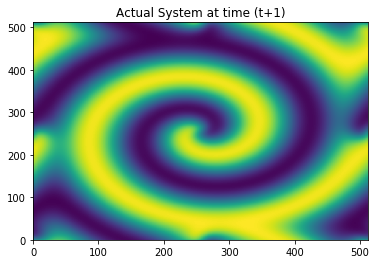

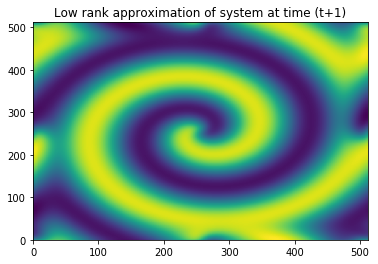

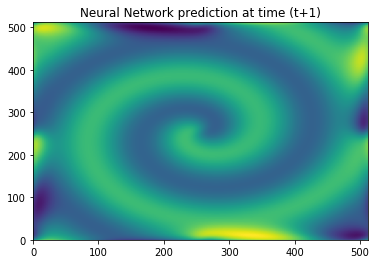

In [25]:
y_NN = model.predict(np.expand_dims(test_in, axis=0))

#print("Expected PC coordinates:\n", np.expand_dims(test_out, axis=0), "\n\n calculated: \n", y_NN.T)

Sigma = np.diag(S)
actual = np.dot(np.matmul(U, Sigma), V[:, -1]).reshape((u.shape[0], u.shape[1]))
low_rank = np.dot(np.matmul(U_r, S_r), V_r[:, -1]).reshape((u.shape[0], u.shape[1]))
NN = np.dot(np.matmul(U_r, S_r), y_NN.T).reshape((u.shape[0], u.shape[1]))

plt.figure()
plt.pcolor(actual)
plt.title('Actual System at time (t+1)')

plt.figure()
plt.pcolor(low_rank)
plt.title('Low rank approximation of system at time (t+1)')

plt.figure()
plt.pcolor(NN)
plt.title('Neural Network prediction at time (t+1)')


